In [ ]:
#Importing all packages
from tkinter import *
from tkinter import ttk
from ttkthemes import themed_tk as tk
from PIL import Image,ImageTk
from datetime import datetime
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import matplotlib.pyplot as plt
import os
import itertools
import numpy as np
import json
import math

In [ ]:
#Creating Lists for GUI
productList = []
for i in range(1,16):
    productList.append("Product" + str(i))
errorMeasureList = ['MSE','MAE','MAPE']
monthList = ['January','February','March','April','May','June','July',
             'August','September','October','November','December']


In [ ]:
#Pulling in Historical Data for Products
products = pd.read_csv('product_data.csv')
products['Week'] = pd.to_datetime(products['Week']).dt.date

In [ ]:
#Pulling in Parameters for Forecasts
parameters = pd.read_json('parameters.json')


In [ ]:
#Function to produce chart of requested data
def getImage(data, productID, month, errorMeasure):
    fig = plt.figure(figsize = (15,7))
    plt.plot(data['Week'],data['Forecast'], '-o')
    plt.grid(True)
    plt.title(f'{productID} Expected Demand for {monthList[month - 1]} 2022')
    plt.xlabel('Week')
    plt.ylabel('Expected Demand')
    
    #Must save the file in order to change image inside gui
    figID = f'Forecasted_Plots/{productID}-{monthList[month-1]}-{errorMeasure}-forecast.png'
    fig.savefig(figID)
    
    #returns name of file that is save (No overright issues)
    return figID

In [ ]:
#Function to produce forecasted data
def forecast(productID, errorMeasure, month):
    #FBProphet uses mae instead of MAE (They are equivalent)
    if errorMeasure == "MAD":
        errorMeasure = 'mae'
        
    #Getting optimal seasonality parameters from parameters dataframe
    #based on users error measure choice    
    cps = parameters[productID][errorMeasure.lower()]['changepoint_prior_scale']
    sps = parameters[productID][errorMeasure.lower()]['seasonality_prior_scale']
    sm = parameters[productID][errorMeasure.lower()]['seasonality_mode']
    
    #Filtering products dataframe by product ID and creating time series
    productDF = products[['Week',productID]]
    timeSeries = productDF.rename(columns={'Week':'ds',productID:'y'})
    
    #Creating a model of the data based on seasonality parameters
    model = Prophet(changepoint_prior_scale = cps,
                    seasonality_prior_scale = sps,
                    seasonality_mode = sm,
                    weekly_seasonality=True)
    model.fit(timeSeries)
    
    #Predicting all of year 2022
    future = model.make_future_dataframe(periods = 52, freq = 'W-MON')
    future.describe(datetime_is_numeric=True)
    fcst = model.predict(future)
    
    #Renaming Forecasted data columns and filtering for only month that the user requested
    forecasted_data = fcst[['ds','yhat']].rename(columns={'ds':'Week','yhat':'Forecast'})
    isRequested = (forecasted_data['Week'] >= '2022-01-03') & (forecasted_data['Week'].dt.month == month)
    requested_forecast = forecasted_data[isRequested]
    
    #Returning dataframe of requested forecast
    return requested_forecast
    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


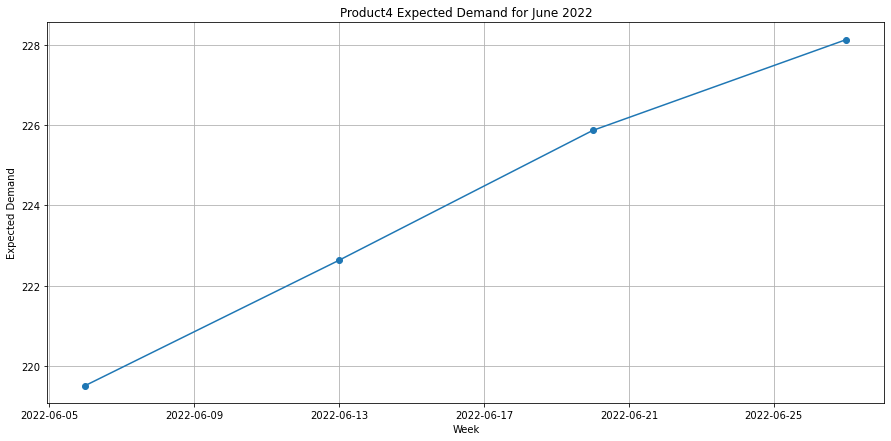

In [12]:
#Function to display graphic and statistics of user selected forecast
def displaySelection():
    #Used try catch to prevent user from not selecting
    try:
        #Getting users selections and assigning to variables
        product = product_listbox.get(product_listbox.curselection())
        error = error_measure_listbox.get(error_measure_listbox.curselection())
        month = monthList.index(month_listbox.get(month_listbox.curselection())) + 1
    #if user doesn't make a selection for each option, another gui window will appear
    #with error message
    except TclError:
        error = Tk()
        error.title("Selection Error")
        error.geometry("200x120")
        error_message = Label(error, text = "Please make all selections!")
        okay_button = Button(error, text="OK", command=error.destroy, width = 10) 
        error_message.place(x = 30,y=20)
        okay_button.place(x = 60, y = 50)
    #calling above functions to get requested data and picture    
    requested_data = forecast(product, error, month)
    figID = getImage(requested_data, product, month, error)
    
    #gathering statistics for table based on requested data
    mean = round(requested_data['Forecast'].mean(),2)
    minimum = round(requested_data['Forecast'].min(),0)
    maximum = round(requested_data['Forecast'].max(),0)
    sd = round(requested_data['Forecast'].std(),2)
    count = requested_data['Forecast'].count()
    ci = (str(round(mean-1.96*(sd/math.sqrt(count)),2)) + " <--> "+
          str(round(mean+1.96*(sd/math.sqrt(count)),2)))
    
    #Setting up statistics table
    my_tree = ttk.Treeview(root, height = 5)
    my_tree['columns'] = ("Statistic","Value")
    my_tree.column("#0",width = 5)
    my_tree.column("Statistic", anchor = CENTER, width = 150)
    my_tree.column("Value",anchor = CENTER, width = 150)
    
    my_tree.heading("#0", text = '',anchor = W)
    my_tree.heading("Statistic", text = 'Statistic',anchor = CENTER)
    my_tree.heading("Value", text = 'Value',anchor = CENTER)
    
    my_tree.insert(parent = '',index = 'end',iid=0,values = ("Mean", mean))
    my_tree.insert(parent = '',index = 'end',iid=3,values = ("Standard Deviation", sd))
    my_tree.insert(parent = '',index = 'end',iid=4,values = ("95% Confidence Interval", ci))
    my_tree.insert(parent = '',index = 'end',iid=1,values = ("Max", maximum))
    my_tree.insert(parent = '',index = 'end',iid=2,values = ("Min", minimum))
    table_label = Label(root, text = f"{product} Statistics for {monthList[month-1]} 2022", bg = "#D3D3D3")
    
    #placing table and label for table
    table_label.place(x = 815, y = 500)
    my_tree.place(x = 750, y = 530)
    
    
    #Replacing image, resizing gui to fit new image and statistics
    new_image = PhotoImage(file = figID)
    root.geometry('1400x675')
    image_label.configure(image = new_image, anchor = NW)
    image_label.image = new_image

#Setting Up Gui Size and Title
root= Tk()
root.title("Data Forecasting")
root.geometry("1100x450")
root.configure(bg = "#A9A9A9")


#Initializing listboxes up List boxes Listbox
product_listbox = Listbox(root, yscrollcommand = True, height = 15, exportselection = 0)
month_listbox = Listbox(root, yscrollcommand = True, height = 12,
                        width = 25, exportselection = 0)
error_measure_listbox = Listbox(root, yscrollcommand = True, height = 3,
                                width = 25, exportselection = 0)

# Add items to listboxes
for item in productList:
    product_listbox.insert(END, item)

for item in errorMeasureList:
    error_measure_listbox.insert(END, item)

for item in monthList:
    month_listbox.insert(END, item)

#Creating labels  
product_label = Label(root, text = "Select Product:", bg = "#D3D3D3")
error_label = Label(root, text = "Select Error Measure:", bg = "#D3D3D3")
month_label = Label(root, text = "Select Month to Display:", bg = "#D3D3D3")


#Creating Buttons to call functions above when clicked
my_button = Button(root, text="Display Forecast", command=displaySelection, width = 30, bg = "#D3D3D3", relief = RAISED) 
exit_button = Button(root, text="Exit", command=root.destroy, width = 30, bg = "#D3D3D3", relief = RAISED) 

#Initializing start image when user launches the gui
img = (Image.open("ncsu.jpg"))
resized_image = img.resize((700,394), Image.ANTIALIAS)
new_image = ImageTk.PhotoImage(resized_image)
image_label = Label(image = new_image, bg = "#A9A9A9", anchor = NW)




#Placing all componenets of GUI
product_listbox.place(x = 20, y = 30)
error_measure_listbox.place(x = 150, y = 30)
month_listbox.place(x = 150, y = 100)

product_label.place(x = 20, y = 10)
error_label.place(x = 150, y = 10)
month_label.place(x = 150, y = 80)

my_button.place(x = 50, y = 310)
exit_button.place(x = 50, y = 350)
image_label.place(x = 350, y = 10, width = 1000, height = 666)



    
#Launching the GUI
root.mainloop()